In [1]:
import networkx as nx
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

In [2]:
%matplotlib notebook

Set the parameters

In [3]:
centers=[(0.,0),(1.,0),(5.,0)]
K=3
n_features=1
cluster_std=1.
SAMPLE=1000

Draw the data

In [4]:
num_components = 3
mu_arr = [0,1.,5.]

X = np.random.normal(loc=mu_arr[0], scale=1, size=SAMPLE)
for i, mu in enumerate(mu_arr[1:]):
    X = np.append(X, np.random.normal(loc=mu, scale=1, size=SAMPLE))

Plot 

<IPython.core.display.Javascript object>


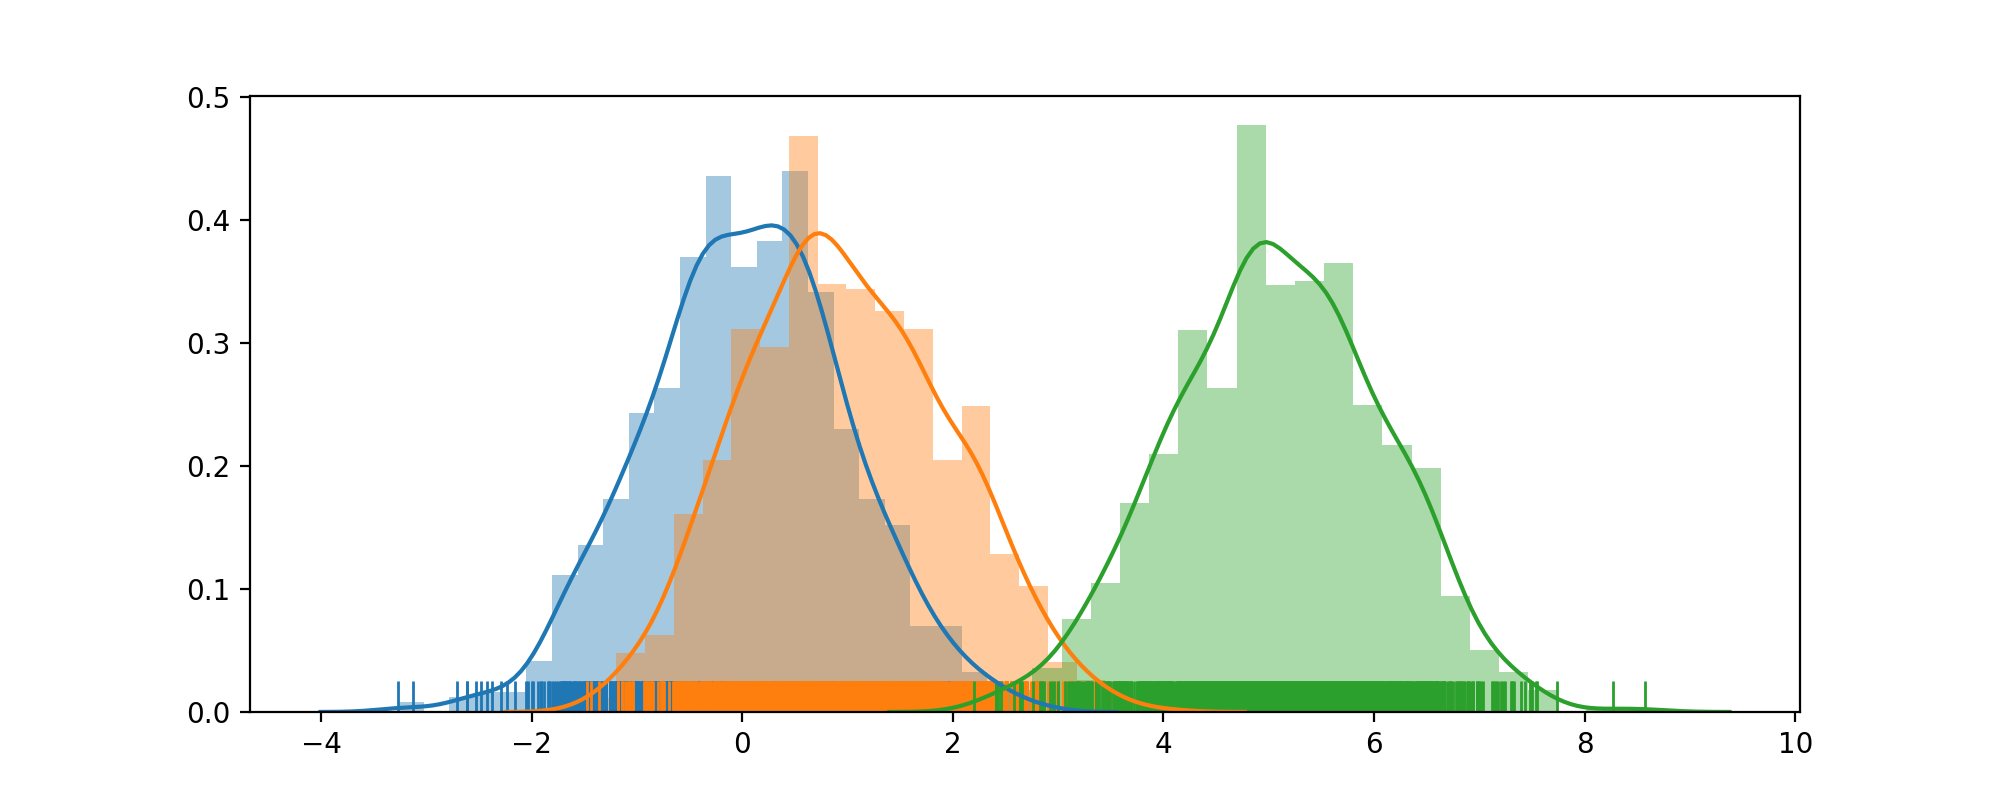

In [5]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.distplot(X[:SAMPLE], ax=ax, rug=True)
sns.distplot(X[SAMPLE:SAMPLE*2], ax=ax, rug=True)
sns.distplot(X[SAMPLE*2:], ax=ax, rug=True)
plt.savefig('figures/L12_GMMexample.pdf')

### Derive the equations for the ELBO.

In [6]:
# see tutorial solutions notes

### Implement CAVI updates for GMM

In [7]:
import numpy as np

class UGMM(object):
    '''Univariate GMM with CAVI'''
    def __init__(self, X, K=2, sigma=1):
        self.X = X
        self.K = K
        self.N = self.X.shape[0]
        self.sigma2 = sigma**2

    def _init(self):
        self.phi = np.random.dirichlet([np.random.random()*np.random.randint(1, 10)]*self.K, self.N)
        self.m = np.random.randint(int(self.X.min()), high=int(self.X.max()), size=self.K).astype(float)
        self.m += self.X.max()*np.random.random(self.K)
        self.s2 = np.ones(self.K) * np.random.random(self.K)
        print('Init mean')
        print(self.m)
        print('Init s2')
        print(self.s2)

    def get_elbo(self):
        #t1 = np.log(self.s2) - self.m/self.sigma2
        #t1 = t1.sum()
        t1 = np.log(self.s2) - 0.5*(self.m**2+self.s2)/self.sigma2
        t1 = t1.sum()
        t2 = -0.5*np.add.outer(self.X**2, self.s2+self.m**2)
        t2 += np.outer(self.X, self.m)
        t2 -= np.log(self.phi)
        t2 *= self.phi
        t2 = t2.sum()
        return t1 + t2

    def fit(self, max_iter=100, tol=1e-10):
        self._init()
        self.elbo_values = [self.get_elbo()]
        self.m_history = [self.m]
        self.s2_history = [self.s2]
        for iter_ in range(1, max_iter+1):
            self._cavi()
            self.m_history.append(self.m)
            self.s2_history.append(self.s2)
            self.elbo_values.append(self.get_elbo())
            if iter_ % 5 == 0:
                print(iter_, self.m_history[iter_])
            if np.abs(self.elbo_values[-2] - self.elbo_values[-1]) <= tol:
                print('ELBO converged with ll %.3f at iteration %d'%(self.elbo_values[-1],
                                                                     iter_))
                break

        if iter_ == max_iter:
            print('ELBO ended with ll %.3f'%(self.elbo_values[-1]))


    def _cavi(self):
        self._update_phi()
        self._update_mu()

    def _update_phi(self):
        t1 = np.outer(self.X, self.m)
        t2 = -(0.5*self.m**2 + 0.5*self.s2)
        exponent = t1 + t2[np.newaxis, :]
        self.phi = np.exp(exponent)
        self.phi = self.phi / self.phi.sum(1)[:, np.newaxis]

    def _update_mu(self):
        self.m = (self.phi*self.X[:, np.newaxis]).sum(0) * (1/self.sigma2 + self.phi.sum(0))**(-1)
        assert self.m.size == self.K
        #print(self.m)
        self.s2 = (1/self.sigma2 + self.phi.sum(0))**(-1)
        assert self.s2.size == self.K

### Fit the model to the data

In [8]:
ugmm = UGMM(X, 3)
ugmm.fit()

Init mean
[6.2410525  9.13527057 8.72738357]
Init s2
[0.2201682  0.38314069 0.90148173]
5 [0.4293147  4.86267912 4.94846692]
10 [0.41860257 4.66653231 5.09123209]
15 [0.37471315 4.05386295 5.44633126]
20 [0.25549065 3.12590182 5.46272495]
25 [0.02111787 1.52214245 5.2150018 ]
30 [0.04850891 1.01119115 5.09564308]
35 [0.09187151 0.94485853 5.08325129]
40 [0.10496788 0.92748187 5.08057372]
45 [0.10917134 0.92202553 5.07977026]
50 [0.11056573 0.92022668 5.07950904]
55 [0.11103355 0.91962434 5.07942198]
60 [0.11119112 0.91942161 5.07939272]
65 [0.11124425 0.91935326 5.07938286]
70 [0.11126218 0.9193302  5.07937953]
75 [0.11126823 0.91932242 5.07937841]
80 [0.11127027 0.91931979 5.07937803]
ELBO converged with ll -204.579 at iteration 82


### Plot results at convergence

<IPython.core.display.Javascript object>


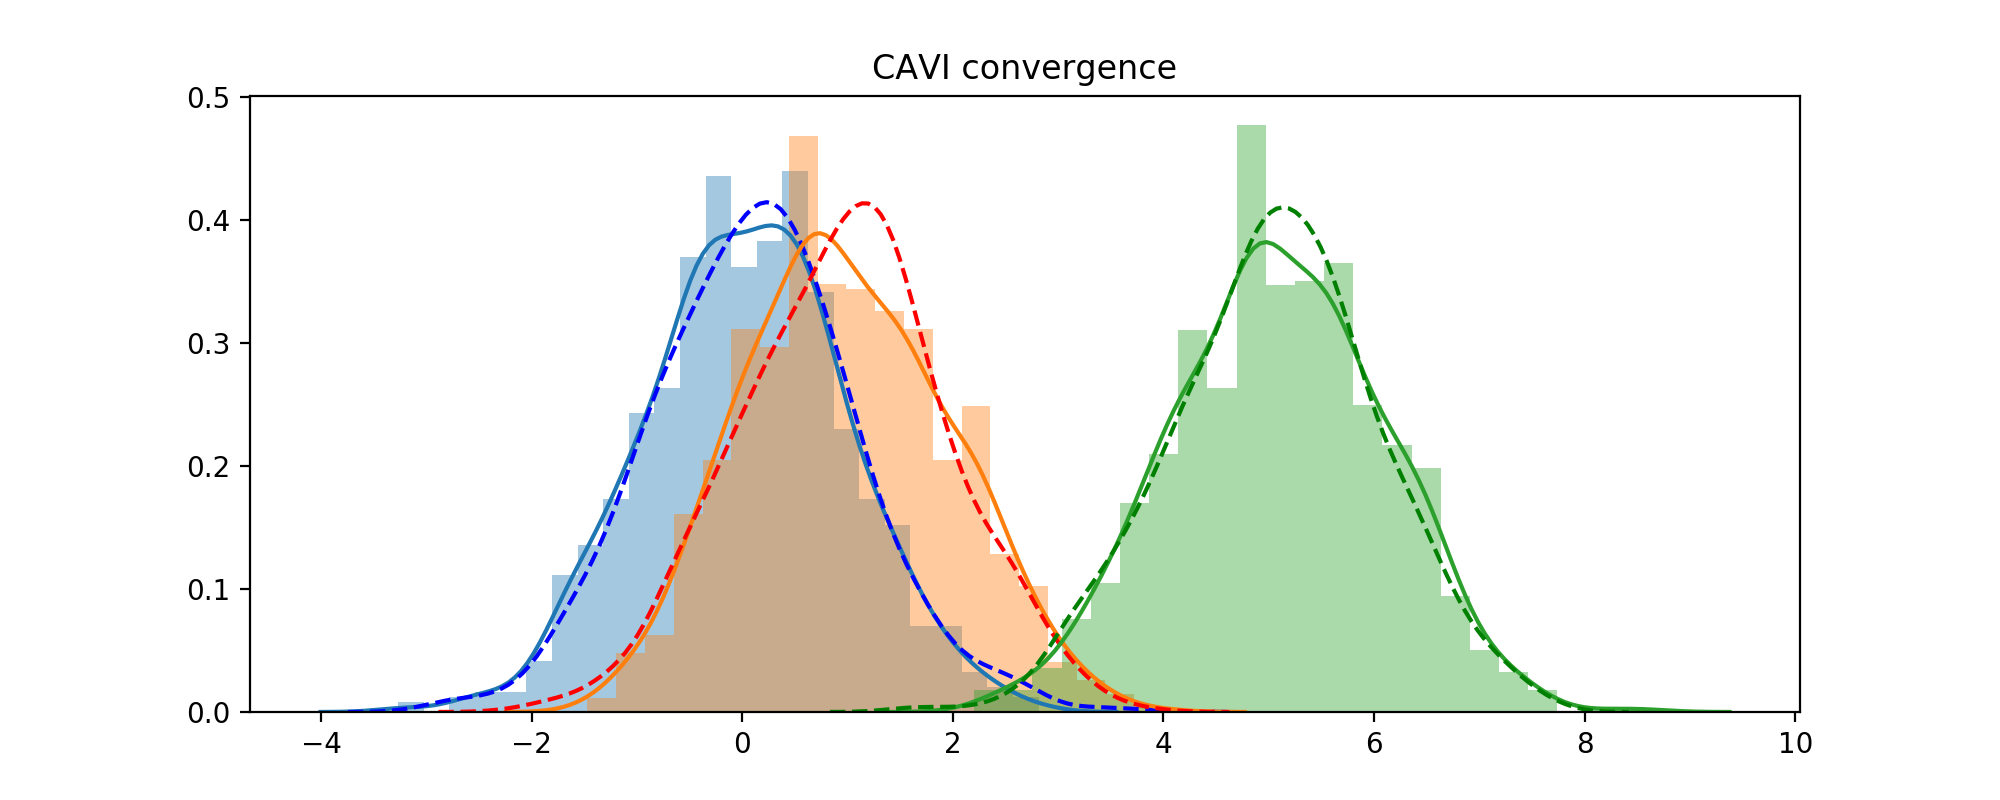

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.distplot(X[:SAMPLE], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(ugmm.m[0], 1, SAMPLE), color='b', hist=False, kde=True,kde_kws={'linestyle':'--'})
sns.distplot(X[SAMPLE:SAMPLE*2], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(ugmm.m[1], 1, SAMPLE), color='r', hist=False, kde=True,kde_kws={'linestyle':'--'})
sns.distplot(X[SAMPLE*2:], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(ugmm.m[2], 1, SAMPLE), color='g', hist=False, kde=True,kde_kws={'linestyle':'--'})
ax.set(title='CAVI convergence')
plt.savefig('figures/L12_GMMexample_itConv.pdf')

### Plot ELBO  
Detect changing points in the ELBO.

<IPython.core.display.Javascript object>


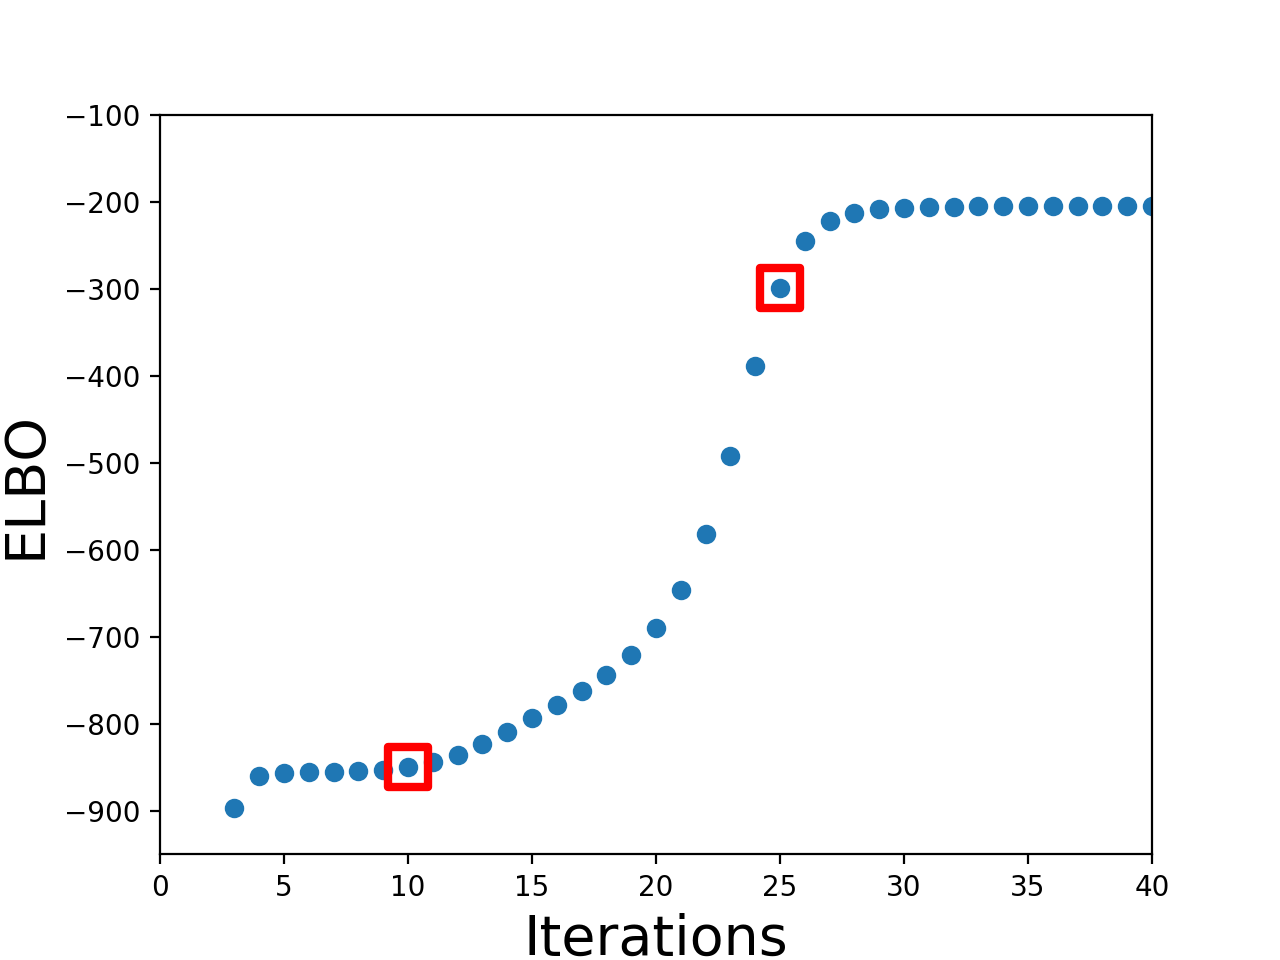

In [16]:
fs=20

it1=10
it2=25
plt.figure()
plt.scatter(np.arange(len(ugmm.elbo_values)),ugmm.elbo_values)
plt.scatter(it1,ugmm.elbo_values[it1],marker='s',facecolors='none',edgecolors='r',s=200, linewidth=3)
plt.scatter(it2,ugmm.elbo_values[it2],marker='s',facecolors='none',edgecolors='r',s=200, linewidth=3)
plt.xlim([0,40])
plt.ylim([-950,-100])
plt.xlabel('Iterations',fontsize=fs)
plt.ylabel('ELBO',fontsize=fs)
plt.savefig('figures/L12_GMMexample_ELBO.pdf')

### Plot result at the beginning and at the changing points.

<IPython.core.display.Javascript object>


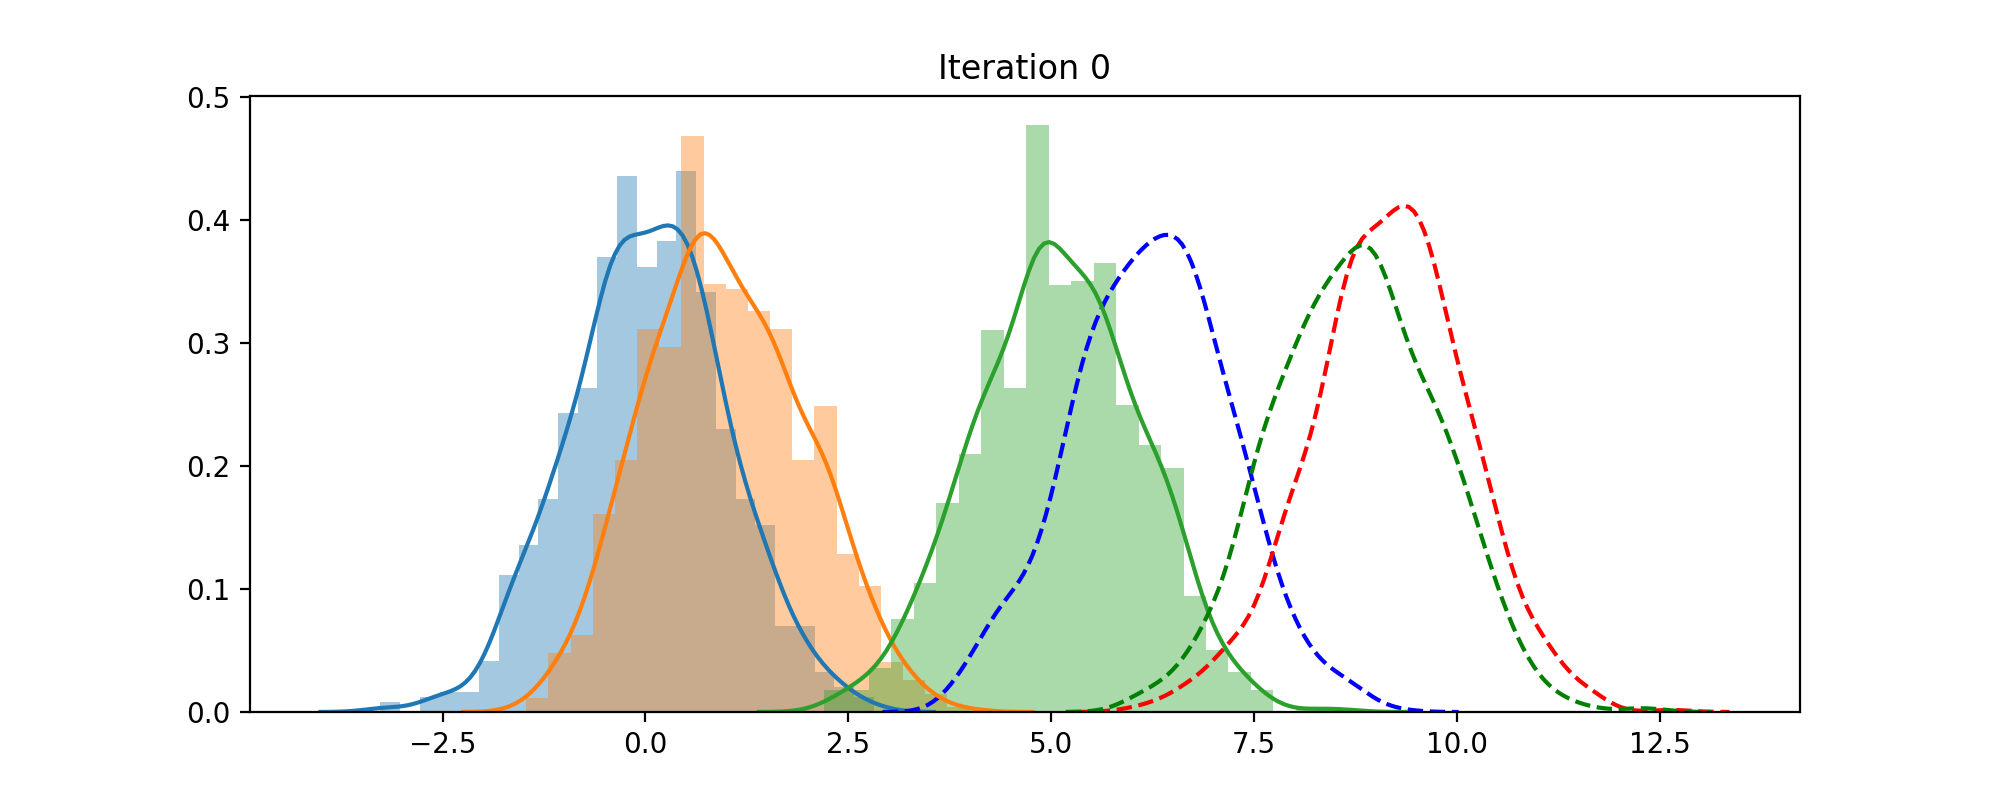

In [17]:
it=0
fig, ax = plt.subplots(figsize=(10, 4))
sns.distplot(X[:SAMPLE], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(ugmm.m_history[it][0], 1, SAMPLE), color='b', hist=False, kde=True,kde_kws={'linestyle':'--'})
sns.distplot(X[SAMPLE:SAMPLE*2], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(ugmm.m_history[it][1], 1, SAMPLE), color='r', hist=False, kde=True,kde_kws={'linestyle':'--'})
sns.distplot(X[SAMPLE*2:], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(ugmm.m_history[it][2], 1, SAMPLE), color='g', hist=False, kde=True,kde_kws={'linestyle':'--'})
ax.set(title=f'Iteration {it}')
plt.savefig('figures/L12_GMMexample_it0.pdf')

<IPython.core.display.Javascript object>


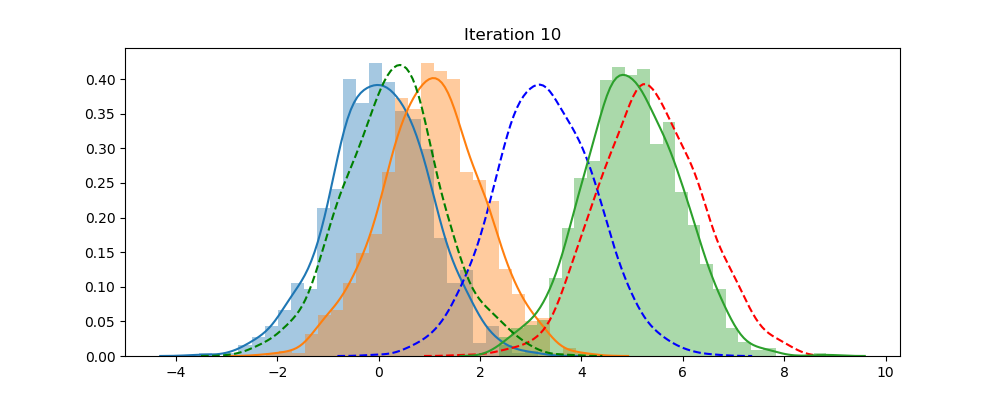

In [40]:
it=it1
fig, ax = plt.subplots(figsize=(10, 4))
sns.distplot(X[:SAMPLE], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(ugmm.m_history[it][0], 1, SAMPLE), color='b', hist=False, kde=True,kde_kws={'linestyle':'--'})
sns.distplot(X[SAMPLE:SAMPLE*2], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(ugmm.m_history[it][1], 1, SAMPLE), color='r', hist=False, kde=True,kde_kws={'linestyle':'--'})
sns.distplot(X[SAMPLE*2:], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(ugmm.m_history[it][2], 1, SAMPLE), color='g', hist=False, kde=True,kde_kws={'linestyle':'--'})
ax.set(title=f'Iteration {it1}')
plt.savefig('figures/L12_GMMexample_it1.pdf')

<IPython.core.display.Javascript object>


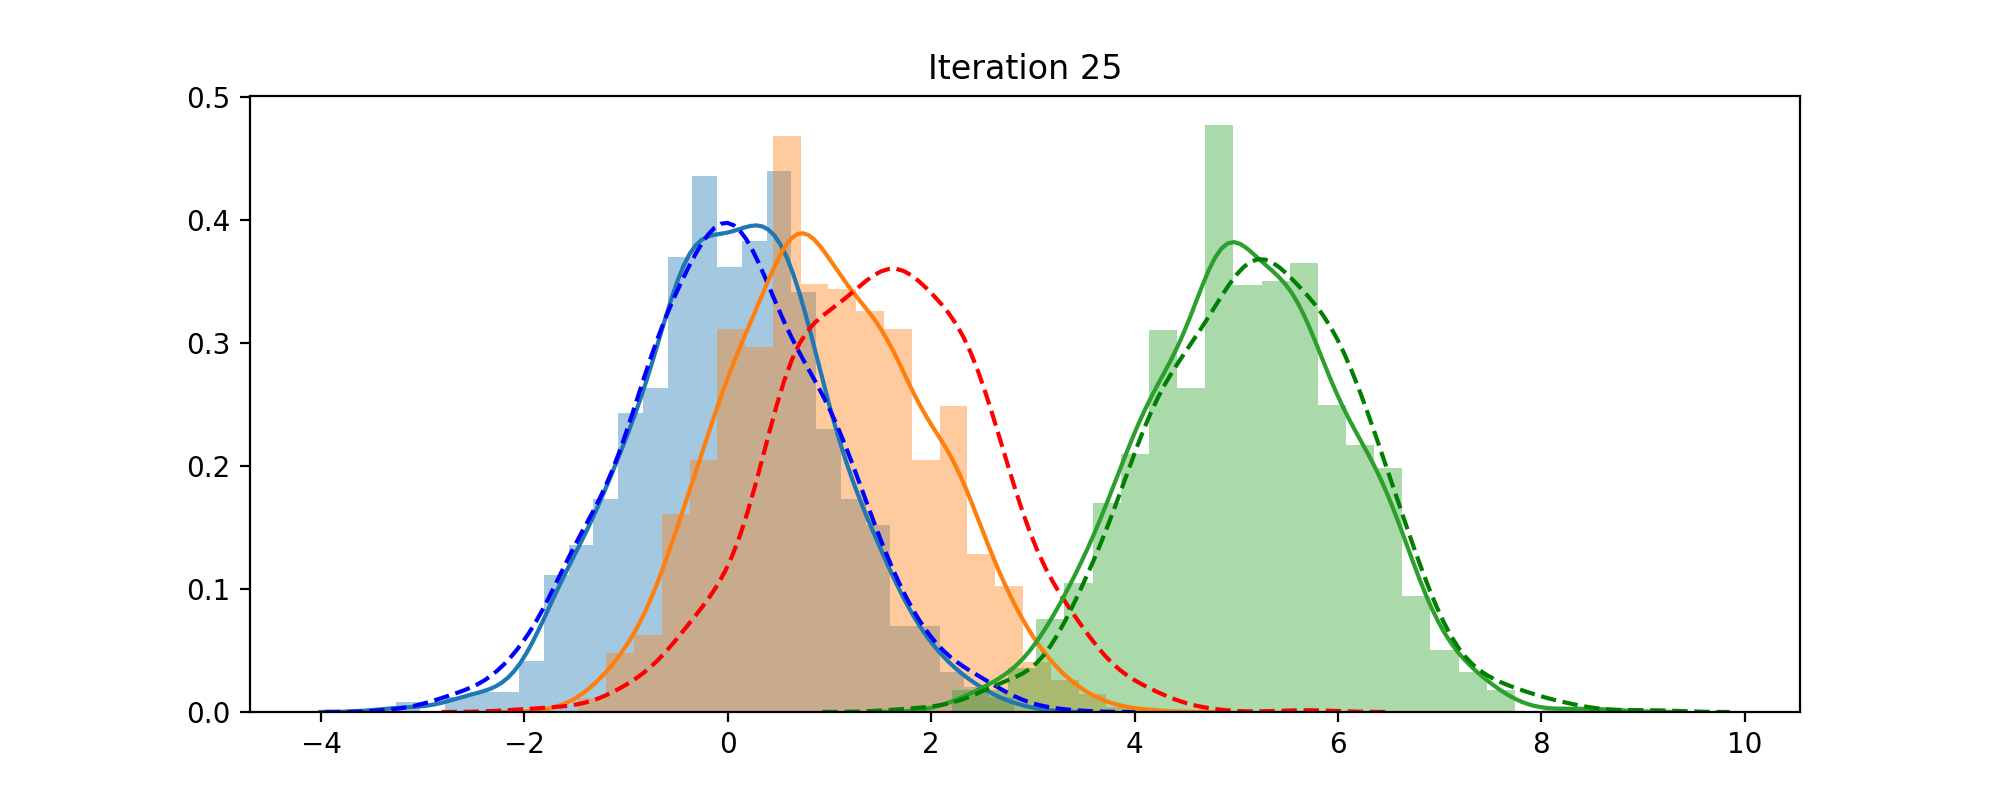

In [18]:
it=it2
fig, ax = plt.subplots(figsize=(10, 4))
sns.distplot(X[:SAMPLE], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(ugmm.m_history[it][0], 1, SAMPLE), color='b', hist=False, kde=True,kde_kws={'linestyle':'--'})
sns.distplot(X[SAMPLE:SAMPLE*2], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(ugmm.m_history[it][1], 1, SAMPLE), color='r', hist=False, kde=True,kde_kws={'linestyle':'--'})
sns.distplot(X[SAMPLE*2:], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(ugmm.m_history[it][2], 1, SAMPLE), color='g', hist=False, kde=True,kde_kws={'linestyle':'--'})
ax.set(title=f'Iteration {it2}')
plt.savefig('figures/L12_GMMexample_it2.pdf')

### Accuracy

In [19]:
# greedily choose cluster correspondence to maximize accuracy
# map cluster number from variational approximation to ground truth
var_assignments = ugmm.phi.argmax(axis=1)
var_to_gt = dict()
for k in range(K):
    gt_k = max(
        set(range(K)).difference(set(var_to_gt.values())),
        key = lambda kk: (var_assignments[kk * SAMPLE : (kk + 1) * SAMPLE] == k).sum()
    )
    var_to_gt[k] = gt_k

In [20]:
var_assignments = np.vectorize(var_to_gt.get)(var_assignments)
acc = (var_assignments == np.repeat(range(K), SAMPLE)).sum() / X.shape[0]
print('Accuracy attained:', acc)

Accuracy attained: 0.7743333333333333
